In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

plt.style.use("ggplot")

print(tf.test.is_built_with_cuda())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))




True
Num GPUs Available:  1


In [2]:
RECORDS_PATH = "../data/records"
TRAIN_FILENAMES = tf.io.gfile.glob(RECORDS_PATH + "/train/train_*.tfrecord")
VAL_FILENAMES = tf.io.gfile.glob(RECORDS_PATH + "/val/val_*.tfrecord")
VISUAL_FILENAMES = ["../data/records/visual.tfrecord"]

print(f"Number of training files: {len(TRAIN_FILENAMES)}")
print(f"Number of validation files: {len(VAL_FILENAMES)}")

Number of training files: 203
Number of validation files: 26


In [3]:
EMBEDDING_DIM = 16
JUDGMENT_DIM = 4
BEATMAP_CONTEXT_DIM = 4

FEATURE_DESCRIPTION = {
    "embeddings": tf.io.VarLenFeature(dtype = tf.float32),
    "judgments": tf.io.VarLenFeature(dtype = tf.float32),
    "beatmap_context": tf.io.FixedLenFeature([8], dtype = tf.float32),
    "replay_length": tf.io.FixedLenFeature([], dtype = tf.int64),
}

### Build TF Dataset Loader

In [4]:
NOTES_PER_EXAMPLE = 8
NOTES_PER_REPLAY = 256

def reformat_example(example):

    feature_tensor_slices = []
    label_tensor_slices = []

    replay_len = example["replay_length"]
    embeddings = tf.reshape( example["embeddings"].values, [replay_len, EMBEDDING_DIM])
    judgments  = tf.reshape( example["judgments"].values, [replay_len, JUDGMENT_DIM])
    beatmap_context = tf.gather( example["beatmap_context"], indices = [0, 1, 2, 5] ) # discard all mods (but hd) and stack leniency
    beatmap_context = tf.reshape( beatmap_context , [1, BEATMAP_CONTEXT_DIM ] )
     
    for note_idx in range(NOTES_PER_REPLAY):
        feature_tensor_slices.append(
            tf.concat([
                beatmap_context, 
                tf.reshape(embeddings[replay_len - note_idx - NOTES_PER_EXAMPLE : replay_len - note_idx , :], [1, NOTES_PER_EXAMPLE * EMBEDDING_DIM])
            ], axis = 1)
        )
        label_tensor_slices.append(
            tf.reshape(judgments[replay_len - note_idx - 1, :], [1, JUDGMENT_DIM])
        )
    
    feature_tensor = tf.concat(feature_tensor_slices, axis = 0)
    label_tensor = tf.concat(label_tensor_slices, axis = 0)
    
    feature_dataset = tf.data.Dataset.from_tensor_slices(feature_tensor)
    label_dataset = tf.data.Dataset.from_tensor_slices(label_tensor)
    
    return tf.data.Dataset.zip((feature_dataset, label_dataset))


def filter_example_len(example):
    return tf.greater_equal(example["replay_length"], NOTES_PER_EXAMPLE + NOTES_PER_REPLAY)

def filter_example_ez(example):
    return tf.less(example["beatmap_context"][4], 0.9 ) 

def filter_example_dt(example):
    return tf.less(example["beatmap_context"][6], 0.9 ) 
        
def filter_example_hr(example):
    return tf.less(example["beatmap_context"][7], 0.9 ) 
            

def parse_example(raw_data):
    example_obj = tf.io.parse_single_example(raw_data, FEATURE_DESCRIPTION)
    return example_obj


In [75]:
BATCH_SIZE = 256
SHUFFLE_BUFFER_SIZE = 4096

def load_dataset(filenames):

    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False  # disable order, increase speed

    dataset = tf.data.TFRecordDataset(
        filenames,
        compression_type = "ZLIB"
    ) 

    dataset = dataset.with_options(
        ignore_order
    ) 

    dataset = dataset.map(
        parse_example, num_parallel_calls = tf.data.AUTOTUNE
    )

    return dataset


def get_dataset(filenames):

    dataset = load_dataset(filenames)
    dataset = dataset.filter(filter_example_len)
    dataset = dataset.filter(filter_example_ez)
    dataset = dataset.filter(filter_example_dt)
    dataset = dataset.filter(filter_example_hr)
    dataset = dataset.flat_map(reformat_example)
    dataset = dataset.shuffle(SHUFFLE_BUFFER_SIZE, reshuffle_each_iteration = True)
    dataset = dataset.prefetch(buffer_size = tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)

    return dataset

### Do Grid Search

In [15]:
def build_naive_model(num_hidden_layers, hidden_layer_size, pct_dropout):
    
    inputs = tf.keras.layers.Input(shape = [NOTES_PER_EXAMPLE * EMBEDDING_DIM + BEATMAP_CONTEXT_DIM,])
    
    x = tf.keras.layers.Dense(hidden_layer_size, activation = "relu", name = "hidden_0")(inputs)
    x = tf.keras.layers.Dropout(pct_dropout, name = "dropout_0")(x)

    for i in range(1, num_hidden_layers):
        x = tf.keras.layers.Dense(hidden_layer_size, activation = "relu", name = f"hidden_{i}")(x)
        x = tf.keras.layers.Dropout(pct_dropout, name = f"dropout_{i}")(x)

    outputs = tf.keras.layers.Dense(JUDGMENT_DIM, activation = "softmax", name = "output_layer")(x)

    model = tf.keras.Model(inputs = inputs, outputs = outputs, name = f"{num_hidden_layers}_{hidden_layer_size}_{pct_dropout}")

    return model


def get_lr_schedule(init_learning_rate, decay_step_count):
    return tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate = init_learning_rate, decay_steps = decay_step_count, decay_rate = 0.96, staircase = True
    )
    
def get_optimizer(idx):
    if idx == 0:
        return tf.keras.optimizers.Adam()
    if idx == 1:
        return tf.keras.optimizers.Adam(clipnorm = 1)
    if idx == 2:
        return tf.keras.optimizers.Adam(learning_rate = get_lr_schedule(0.001, 1000))
    if idx == 3:
        return tf.keras.optimizers.Adam(clipnorm = 1, learning_rate = get_lr_schedule(0.001, 1000))
    

In [30]:
NUM_HIDDEN_LAYERS = 5
HIDDEN_LAYER_SIZE = 512
DROPOUT_PERCENTS = [0.1, 0.05, 0]
NUM_OPTIMIZERS = 4

NUM_EPOCHS = 1

histories = []

for d_idx, dropout_percent in enumerate(DROPOUT_PERCENTS):
    for o_idx in range(NUM_OPTIMIZERS):
            
            print(f"\n\nTraining model {(dropout_percent, o_idx)}\n")
            
            model = build_naive_model(
                num_hidden_layers = NUM_HIDDEN_LAYERS,
                hidden_layer_size = HIDDEN_LAYER_SIZE,
                pct_dropout = dropout_percent,   
            )
            
            opt = get_optimizer(o_idx)
            
            model.compile(
                optimizer = opt,
                loss = "categorical_crossentropy",
                metrics = [
                    tf.keras.metrics.CategoricalAccuracy(name = "categorical_acc")
                ]
            )
            
            train_dataset = get_dataset(TRAIN_FILENAMES)
            val_dataset = get_dataset(VAL_FILENAMES)
            
            history = model.fit(
                
                train_dataset,
                epochs = NUM_EPOCHS,
                validation_data = val_dataset,
                
            )
            
            model.save(f"naive_{d_idx}_{o_idx}.keras")
            
            histories.append([
                (d_idx, o_idx), 
                history
            ])



Training model (0.1, 0)

127441/127441 [==============================] - 934s 7ms/step - loss: 0.3525 - categorical_acc: 0.9035 - val_loss: 0.3478 - val_categorical_acc: 0.9036


Training model (0.1, 1)

127441/127441 [==============================] - 1368s 11ms/step - loss: 0.3504 - categorical_acc: 0.9035 - val_loss: 0.3496 - val_categorical_acc: 0.9036


Training model (0.1, 2)

127441/127441 [==============================] - 941s 7ms/step - loss: 0.3455 - categorical_acc: 0.9035 - val_loss: 0.3407 - val_categorical_acc: 0.9036


Training model (0.1, 3)

127441/127441 [==============================] - 1434s 11ms/step - loss: 0.3450 - categorical_acc: 0.9035 - val_loss: 0.3411 - val_categorical_acc: 0.9036


Training model (0.05, 0)

127441/127441 [==============================] - 971s 8ms/step - loss: 0.3489 - categorical_acc: 0.9035 - val_loss: 0.3454 - val_categorical_acc: 0.9036


Training model (0.05, 1)

127441/127441 [==============================] - 1440s 11ms/step - 

### Visualize Performance

In [40]:
MODEL_PATH = "../models/naive/naive_2_2.keras"
model = tf.keras.models.load_model(MODEL_PATH)

In [74]:
context_labels = [
    "ar",
    "od",
    "cs",
    "hd",
]

emb_labels = [
    "x_pos",
    "y_pos",
    "in_x_offset",
    "in_y_offset",
    "in_dist",
    "in_timedelta",
    "out_x_offset",
    "out_y_offset",
    "out_dist",
    "out_timedelta",
    "angle",
    "is_slider",
    "slider_duration",
    "slider_length",
    "slider_num_ticks",
    "slider_num_beats"
]

true_labels = [
    "300",
    "100",
    "50",
    "miss"
]

prob_labels = [
    "p_300",
    "p_100",
    "p_50",
    "p_miss"
]

val_dataset = get_dataset(VAL_FILENAMES)
features, labels = next(iter(val_dataset))
probs = model.predict_on_batch(features)

notes_df = pd.DataFrame(
    np.concatenate(
        (features[:, :BEATMAP_CONTEXT_DIM], features[:, -EMBEDDING_DIM:], labels, probs), 
        axis = 1
    ), columns = context_labels + emb_labels + true_labels + prob_labels
)

print(len(notes_df))
notes_df.head()

2048


,ar,od,cs,hd,x_pos,y_pos,in_x_offset,in_y_offset,in_dist,in_timedelta,...,slider_num_ticks,slider_num_beats,300,100,50,miss,p_300,p_100,p_50,p_miss
0,9.7,9.0,4.5,0.0,459.575989,253.576004,3.424,3.424,4.842267,74.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.863626,1.224562e-01,9.952940e-03,0.003965
1,9.0,8.0,4.0,1.0,311.000000,187.000000,79.000,164.000,182.035706,505.0,...,2.0,1.0,1.0,0.0,0.0,0.0,0.989804,8.001552e-11,2.403177e-13,0.010196
2,9.3,8.3,4.0,0.0,244.000000,196.000000,18.000,54.000,56.920998,84.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.843859,1.144902e-01,1.207676e-02,0.029574
3,9.5,9.0,4.3,0.0,178.000000,68.000000,51.000,-197.000,203.494476,349.0,...,2.0,0.5,1.0,0.0,0.0,0.0,0.987876,4.859232e-08,4.495688e-10,0.012124
4,9.0,8.0,4.0,0.0,392.000000,316.000000,272.000,248.000,368.086945,215.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.922983,4.755980e-02,8.161832e-04,0.028641


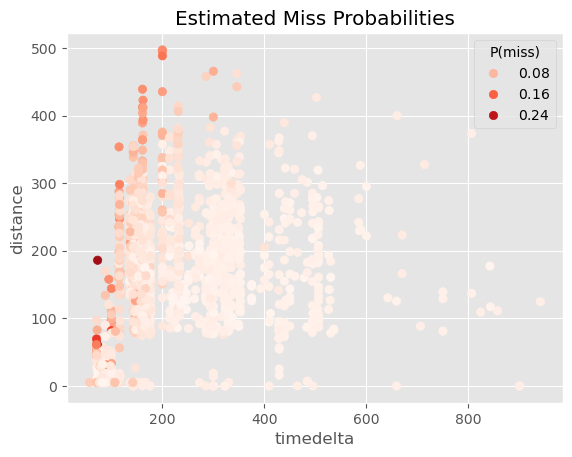

In [76]:
fig, ax = plt.subplots()

plt.title("Estimated Miss Probabilities")

scatter = ax.scatter("in_timedelta", "in_dist", c = "p_miss", cmap = "Reds", data = notes_df)
ax.set_xlabel("timedelta")
ax.set_ylabel("distance")

legend1 = ax.legend(*scatter.legend_elements(num = 4), title = "P(miss)")


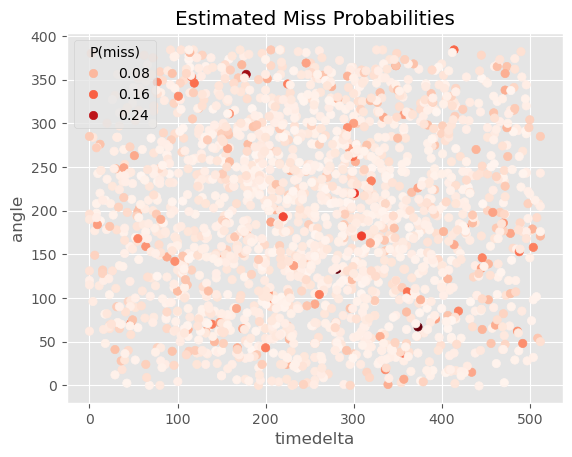

In [80]:
fig, ax = plt.subplots()

plt.title("Estimated Miss Probabilities")

scatter = ax.scatter("x_pos", "y_pos", c = "p_miss", cmap = "Reds", data = notes_df)
ax.set_xlabel("timedelta")
ax.set_ylabel("angle")

legend1 = ax.legend(*scatter.legend_elements(num = 4), title = "P(miss)")

### Visualize Beatmap Difficulty

In [45]:
NUM_VISUAL_TESTS = 597

def load_visual_dataset(filenames):

    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = True 

    dataset = tf.data.TFRecordDataset(
        filenames,
        compression_type = "ZLIB"
    ) 

    dataset = dataset.map(
        parse_example, num_parallel_calls = 1
    )

    return dataset

def get_visual_dataset(filenames):

    dataset = load_visual_dataset(filenames)
    dataset = dataset.flat_map(reformat_example)
    dataset = dataset.batch(NOTES_PER_REPLAY * NUM_VISUAL_TESTS)

    return dataset

In [46]:
visual_dataset = get_visual_dataset(VISUAL_FILENAMES)
visual_df = pd.read_csv("../data/indices/visual_index.csv")

In [47]:
visual_features, visual_labels = next(iter(visual_dataset))
visual_probs = model.predict_on_batch(visual_features)

visual_notes_df = pd.DataFrame(
    np.concatenate(
        (visual_features[:, :BEATMAP_CONTEXT_DIM], visual_features[:, -EMBEDDING_DIM:], visual_labels, visual_probs), 
        axis = 1
    ), columns = context_labels + emb_labels + true_labels + prob_labels
)

print(len(visual_notes_df))
visual_notes_df.head()

152832


,ar,od,cs,hd,x_pos,y_pos,in_x_offset,in_y_offset,in_dist,in_timedelta,...,slider_num_ticks,slider_num_beats,300,100,50,miss,p_300,p_100,p_50,p_miss
0,9.3,8.4,4.2,1.0,482.0,30.0,379.0,-354.0,518.610657,428.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.826342,0.126367,0.013385,0.033906
1,9.3,8.4,4.2,1.0,103.0,384.0,-7.0,41.0,41.593269,86.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.835128,0.123735,0.014893,0.026243
2,9.3,8.4,4.2,1.0,110.0,343.0,-7.0,41.0,41.593269,86.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.857324,0.121092,0.012856,0.008728
3,9.3,8.4,4.2,1.0,117.0,302.0,-7.0,41.0,41.593269,85.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.857116,0.124361,0.011607,0.006916
4,9.3,8.4,4.2,1.0,124.0,261.0,-30.0,87.0,92.027168,343.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.888098,0.100214,0.006964,0.004724


In [49]:
visual_notes_df["neg_log_p_300"] = visual_notes_df["p_300"].apply(lambda p: -np.log(p))
visual_notes_df["neg_log_p_300_or_100"] = visual_notes_df.apply(lambda row: -np.log(row["p_300"] + row["p_100"]), axis = 1)
visual_notes_df["neg_log_p_hit"] = visual_notes_df["p_miss"].apply(lambda p: -np.log(1-p))

SSes = []
Ses = []
FCs = []

for idx in range(NUM_VISUAL_TESTS):
    SSes.append( np.sum( visual_notes_df["neg_log_p_300"].iloc[idx * NOTES_PER_REPLAY : (idx + 1) * NOTES_PER_REPLAY]) )
    Ses.append( np.sum( visual_notes_df["neg_log_p_300_or_100"].iloc[idx * NOTES_PER_REPLAY : (idx + 1) * NOTES_PER_REPLAY]) )
    FCs.append( np.sum( visual_notes_df["neg_log_p_hit"].iloc[idx * NOTES_PER_REPLAY : (idx + 1) * NOTES_PER_REPLAY]) )

visual_df["neg_loglik_SS"] = SSes
visual_df["neg_loglik_300s_and_100s"] = Ses
visual_df["neg_loglik_FC"] = FCs

In [50]:
visual_df.sort_values(by = "neg_loglik_SS", ascending = False)[:32]

,beatmap_name,mods,stars_live,neg_loglik_SS,neg_loglik_300s_and_100s,neg_loglik_FC
330,e-ZUKA - Assailant in the Night [a],NM,8.256209,214.113285,68.424132,17.548393
208,Various Artist - Oriental's Long Stream Practi...,NM,6.309763,155.619763,38.536662,7.019523
179,isoganakya - isogu (Stream Practice Maps) [300...,NM,7.451979,136.484780,41.314672,11.710999
549,Silvia - Vertex Gamma [GAMMA],NM,7.887110,126.255403,40.652901,15.415759
435,Silvia - Vertex Gamma [GAMMA],NF,7.887110,126.255403,40.652901,15.415759
375,Unknown Artist - LEGIA TO CHUJE [Ultimate 2021...,NM,6.695980,124.325052,35.206948,9.666620
53,Nekrogoblikon - The Skin Thief [Murder],NM,7.071175,110.887302,32.189803,14.567839
242,Silvia - Vertex Delta [DELTA],NM,7.216998,105.028873,30.916034,11.232050
555,xi - FREEDOM DiVE [Arles],NF,9.700611,99.581706,53.355474,46.938360
250,odaxelagnia - nicololi [for weak CS3 HP2],NM,9.146768,98.341073,70.466756,69.521330


In [85]:
visual_df.sort_values(by = "neg_loglik_300s_and_100s", ascending = False)[:32]

,beatmap_name,mods,stars_live,neg_loglik_SS,neg_loglik_300s_and_100s,neg_loglik_FC
250,odaxelagnia - nicololi [for weak CS3 HP2],NM,9.146768,98.341073,70.466756,69.521330
330,e-ZUKA - Assailant in the Night [a],NM,8.256209,214.113285,68.424132,17.548393
41,va - jump pack [A FOOL MOON NIGHT],NF,10.084165,92.266129,63.846510,62.722056
555,xi - FREEDOM DiVE [Arles],NF,9.700611,99.581706,53.355474,46.938360
39,umu. - humanly [facade],NM,8.941363,74.338754,52.412027,51.716325
533,Various Artists - Julaaaan's Triangle Jump Tra...,NM,8.807588,77.392223,49.236530,48.036644
37,Kobaryo - Tool-Assisted Speedcore (TQBF Frame ...,NF,8.064831,67.567540,47.615158,45.885632
323,Kobaryo - Tool-Assisted Speedcore (TQBF Frame ...,NM,8.064831,67.567540,47.615158,45.885632
376,Camellia feat. Nanahira - Kizuitara Shunkashuu...,HDNF,9.550962,71.501362,46.560812,44.653551
179,isoganakya - isogu (Stream Practice Maps) [300...,NM,7.451979,136.484780,41.314672,11.710999


In [81]:
visual_df.sort_values(by = "neg_loglik_FC", ascending = False)[:32]

,beatmap_name,mods,stars_live,neg_loglik_SS,neg_loglik_300s_and_100s,neg_loglik_FC
250,odaxelagnia - nicololi [for weak CS3 HP2],NM,9.146768,98.341073,70.466756,69.521330
41,va - jump pack [A FOOL MOON NIGHT],NF,10.084165,92.266129,63.846510,62.722056
39,umu. - humanly [facade],NM,8.941363,74.338754,52.412027,51.716325
533,Various Artists - Julaaaan's Triangle Jump Tra...,NM,8.807588,77.392223,49.236530,48.036644
555,xi - FREEDOM DiVE [Arles],NF,9.700611,99.581706,53.355474,46.938360
37,Kobaryo - Tool-Assisted Speedcore (TQBF Frame ...,NF,8.064831,67.567540,47.615158,45.885632
323,Kobaryo - Tool-Assisted Speedcore (TQBF Frame ...,NM,8.064831,67.567540,47.615158,45.885632
376,Camellia feat. Nanahira - Kizuitara Shunkashuu...,HDNF,9.550962,71.501362,46.560812,44.653551
105,HitoshizukuP x Yama - Crazy nighT [EnD],HDNF,8.553635,60.604760,40.312440,39.167156
366,shikata akiko - Katayoku no tori [Arles],NF,8.560101,58.145171,37.849698,35.966829


Text(0, 0.5, 'Neg. Log-likelihood(SS)')

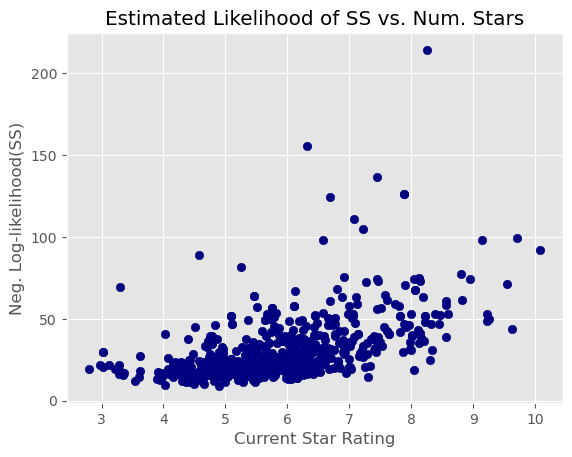

In [83]:
fig, ax = plt.subplots()

plt.title("Estimated Likelihood of SS vs. Num. Stars")

plt.scatter("stars_live", "neg_loglik_SS", data = visual_df, color = "Navy")
ax.set_xlabel("Current Star Rating")
ax.set_ylabel("Neg. Log-likelihood(SS)")

Text(0, 0.5, 'Neg. Log-likelihood(FC)')

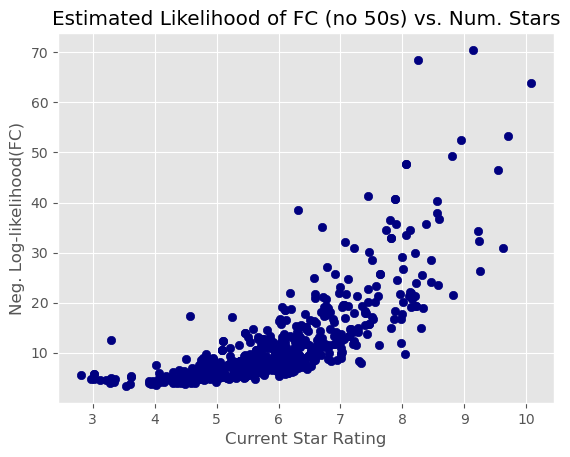

In [86]:
fig, ax = plt.subplots()

plt.title("Estimated Likelihood of FC (no 50s) vs. Num. Stars")

plt.scatter("stars_live", "neg_loglik_300s_and_100s", data = visual_df, color = "Navy")
ax.set_xlabel("Current Star Rating")
ax.set_ylabel("Neg. Log-likelihood(FC)")

Text(0, 0.5, 'Neg. Log-likelihood(FC)')

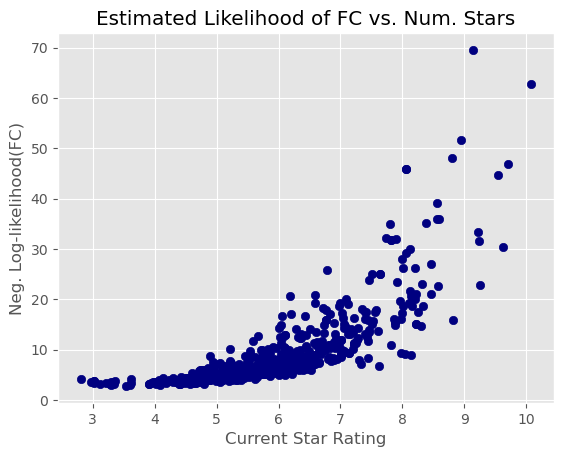

In [84]:
fig, ax = plt.subplots()

plt.title("Estimated Likelihood of FC vs. Num. Stars")

plt.scatter("stars_live", "neg_loglik_FC", data = visual_df, color = "Navy")
ax.set_xlabel("Current Star Rating")
ax.set_ylabel("Neg. Log-likelihood(FC)")

### Some Examples

In [54]:
def plot_replay_idx(replay_idx, visual_notes_df):
    plt.plot(range(1, NOTES_PER_REPLAY + 1), visual_notes_df.iloc[replay_idx * NOTES_PER_REPLAY : (replay_idx + 1) * NOTES_PER_REPLAY]["p_300"][::-1], color = "blue")
    plt.plot(range(1, NOTES_PER_REPLAY + 1), visual_notes_df.iloc[replay_idx * NOTES_PER_REPLAY : (replay_idx + 1) * NOTES_PER_REPLAY]["p_100"][::-1], color = "green")
    plt.plot(range(1, NOTES_PER_REPLAY + 1), visual_notes_df.iloc[replay_idx * NOTES_PER_REPLAY : (replay_idx + 1) * NOTES_PER_REPLAY]["p_50"][::-1], color = "purple")
    plt.plot(range(1, NOTES_PER_REPLAY + 1), visual_notes_df.iloc[replay_idx * NOTES_PER_REPLAY : (replay_idx + 1) * NOTES_PER_REPLAY]["p_miss"][::-1], color = "red")

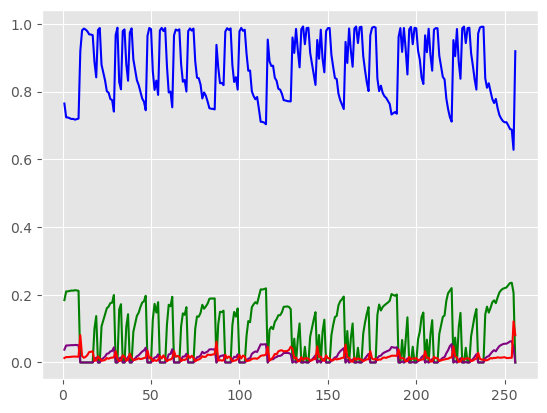

In [55]:
plot_replay_idx(130, visual_notes_df)

#### ZYTOKINE - Dancing Dollz feat. cold kiss - REDALiCE Remix [Extra] (HD)

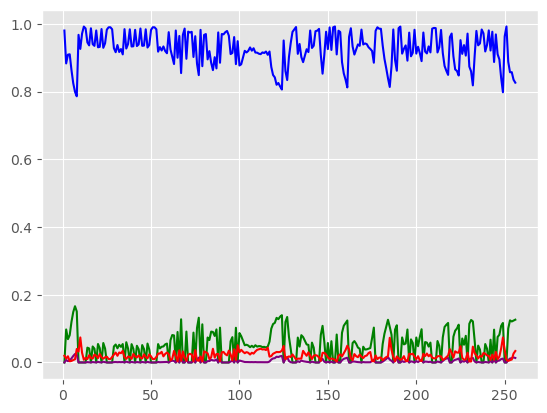

In [56]:
plot_replay_idx(0, visual_notes_df)

#### ayase rie - yuima-ru*world [Real's Insane] (HD)

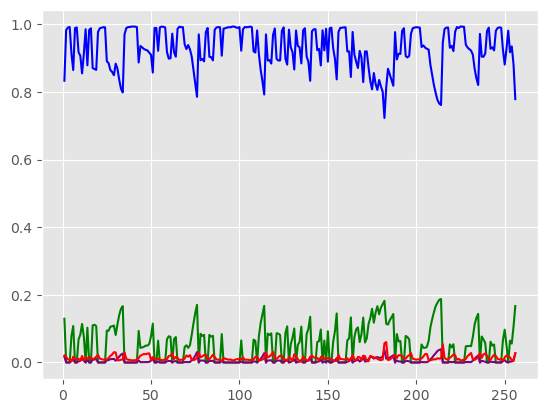

In [57]:
plot_replay_idx(1, visual_notes_df)

#### Sunless Rise - Awakening [Untruth] (NM)

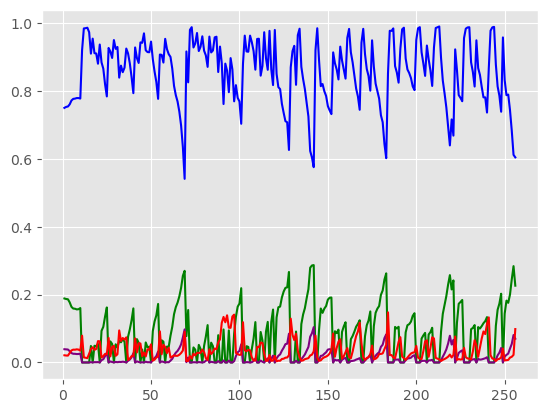

In [58]:
plot_replay_idx(2, visual_notes_df)

#### Ray - km/h (TV Size) [Gotta Go Fast!] (NM)

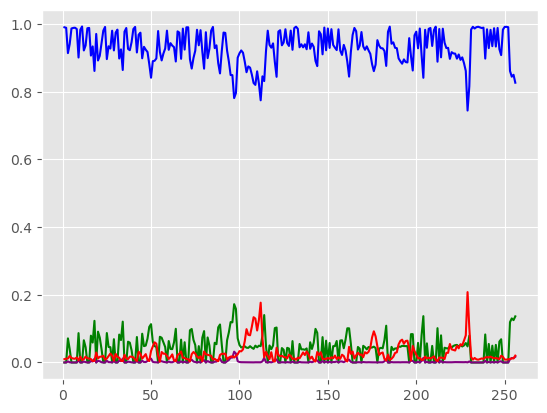

In [59]:
plot_replay_idx(3, visual_notes_df)